# Loan Default Prediction
## Team Members:
* Harish Puvvada         - hp1047
* Vamsi Mohan Ramineedi  - vmr286

Github link: https://github.com/harishpuvvada/LoanDefault-Prediction

In [126]:
import os
import pandas as pd
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

<p>
<span style="color:blue">
> Importing data of Lending club for the years 2012-14
</span>
</p>

In [2]:
dataset = pd.read_csv(r"E:\prep\python\loan_default_prediction\accepted_2007_to_2018Q4.csv")

In [3]:
dataset['last_pymnt_amnt']

0            122.67
1            926.35
2          15813.30
3            829.90
4          10128.96
             ...   
2260696      859.56
2260697      564.56
2260698      329.33
2260699         NaN
2260700         NaN
Name: last_pymnt_amnt, Length: 2260701, dtype: float64

## Data Cleaning

<p>
<span style="color:blue">
> Merged datasets of 2012-14 <br>
> Removed all empty columns ( these are the columns with personal data of the borrowers. These are not disclosed by the company. so we dropped them)<br>
> Target variable(Borrower is a Loan defaulter) - encoded to 0 or 1<br>
</span>
</p>

In [4]:
# dataset = pd.concat([df2012_13, df2014]) #merging 2012 to 2014 datasets
# dataset = dataset.iloc[:,2:111]          #removing empty columns
# empty_cols = [i for i in range(45,72)]   #more empty columns
# dataset = dataset.drop(dataset.columns[empty_cols],axis=1)
data_with_loanstatus_sliced = dataset[(dataset['loan_status']=="Fully Paid") | (dataset['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
Dataset_withBoolTarget= data_with_loanstatus_sliced.replace({"loan_status": di})
dataset['issue_d'] = pd.to_datetime(dataset['issue_d'])
dataset['issue_d'].dtype
dataset = (dataset['issue_d'] >= '2012-01-01') & (dataset['issue_d'] <= '2014-12-31') 

In [5]:
Dataset_withBoolTarget['loan_status'].value_counts()
print("Current shape of dataset :",Dataset_withBoolTarget.shape)
Dataset_withBoolTarget.head(3)

Current shape of dataset : (1345310, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,...,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,...,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,...,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
dataset=Dataset_withBoolTarget.dropna(thresh = 340000,axis=1) #340000 is minimum number of non-NA values
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (1345310, 110)


<p>
<span style="color:blue">
> some more columns were dropped in the below cell. some of them are not related to our target variable and some of them are redundant. <br>
</span>
</p>

In [7]:
# del_col_names = ["delinq_2yrs",  "last_pymnt_d", "chargeoff_within_12_mths","delinq_amnt","emp_title", "term", "emp_title", "pymnt_plan","purpose","title", "zip_code", "verification_status", "dti","earliest_cr_line", "initial_list_status", "out_prncp",
# "pymnt_plan", "num_tl_90g_dpd_24m", "num_tl_30dpd", "num_tl_120dpd_2m", "num_accts_ever_120_pd", "delinq_amnt", 
# "chargeoff_within_12_mths", "total_rec_late_fee", "out_prncp_inv", "issue_d"] #deleting some more columns
# dataset = dataset.drop(labels = del_col_names, axis = 1) 
# print("Current shape of dataset :",dataset.shape)

<p>
<span style="color:blue">
> After indepth research about these rest 52 features, We selected ~20 relevant features using correlation matrix values. After few cells (in this ipython notebook), we used "RFE (Recursive Feature Elimination)" and " PCA(Principle Component Analysis)" do the actual feature selection.<br>
</span>
</p>

In [8]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths",'loan_status'] #'sub_grade' #selecting final features #'addr_state''tax_liens',
Final_data = dataset[features] #19 features with target var
# Final_data["int_rate"] = Final_data["int_rate"].apply(lambda x:float(x[:-1]) ) #reomving % sign, conv to float  - int_rate column
Final_data= Final_data.reset_index(drop=True)
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (1345310, 18)


In [9]:
Final_data.describe().round(2)

,funded_amnt,annual_inc,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
count,1345310.00,1345310.00,1345310.00,1298029.00,1345310.00,1345310.00,1345310.00,1277783.00,1277782.00,1277782.00,1283398.00,1284167.00,1277761.00,1298029.00,1345310.0
mean,14411.56,76247.64,5423.57,1.67,0.22,13.24,11.59,5.64,13.12,181.48,59.94,10186.23,13488.61,4.69,0.2
std,8713.12,69925.10,7118.00,2.00,0.60,4.77,5.47,3.30,16.34,94.51,28.29,15350.84,16289.70,3.19,0.4
min,500.00,0.00,0.00,0.00,0.00,5.31,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.0
25%,8000.00,45780.00,398.52,0.00,0.00,9.75,8.00,3.00,4.00,117.00,38.30,1464.00,3101.00,2.00,0.0
50%,12000.00,65000.00,2042.05,1.00,0.00,12.74,11.00,5.00,8.00,164.00,63.20,4700.00,7407.00,4.00,0.0
75%,20000.00,90000.00,8250.57,3.00,0.00,15.99,14.00,7.00,16.00,230.00,84.80,12383.00,18717.00,6.00,0.0
max,40000.00,10999200.00,42192.05,51.00,86.00,30.99,90.00,63.00,438.00,852.00,339.60,559912.00,958084.00,64.00,1.0


## Data Transformation


<p>
<span style="color:blue">
> Grade - Borrower's grade given basing on his/her past history - encoded to numerical values. <br>
> home_ownership - this is feature in the dataset which had to be encoded to numerical values. <br>
> Emp_Length - this feature was not formatted properly. It has some values which was in the format like "10+years","5years"...etc. we changed them to numerical values in the below cell.
</span>
</p>

In [10]:
#Data encoding
Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
Final_data["emp_length"] = Final_data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
Final_data["emp_length"] = Final_data["emp_length"].fillna(0).apply(lambda x:int(x))
print("Current shape of dataset :",Final_data.shape)
Final_data.head()

Current shape of dataset : (1345310, 18)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,3600.0,10,55000.0,6,5,122.67,1.0,0.0,13.99,7.0,4.0,3.0,128.0,37.2,1506.0,20701.0,4.0,0
1,24700.0,10,65000.0,6,5,926.35,4.0,0.0,11.99,22.0,5.0,2.0,192.0,27.1,57830.0,9733.0,4.0,0
2,20000.0,10,63000.0,6,6,15813.30,5.0,0.0,10.78,6.0,3.0,14.0,184.0,55.9,2737.0,31617.0,6.0,0
3,10400.0,3,104433.0,6,2,10128.96,6.0,0.0,22.45,12.0,6.0,4.0,210.0,77.5,4567.0,27644.0,10.0,0
4,11950.0,4,34000.0,5,5,7653.56,0.0,0.0,13.44,5.0,3.0,32.0,54.0,91.0,844.0,2560.0,0.0,0


<Axes: >

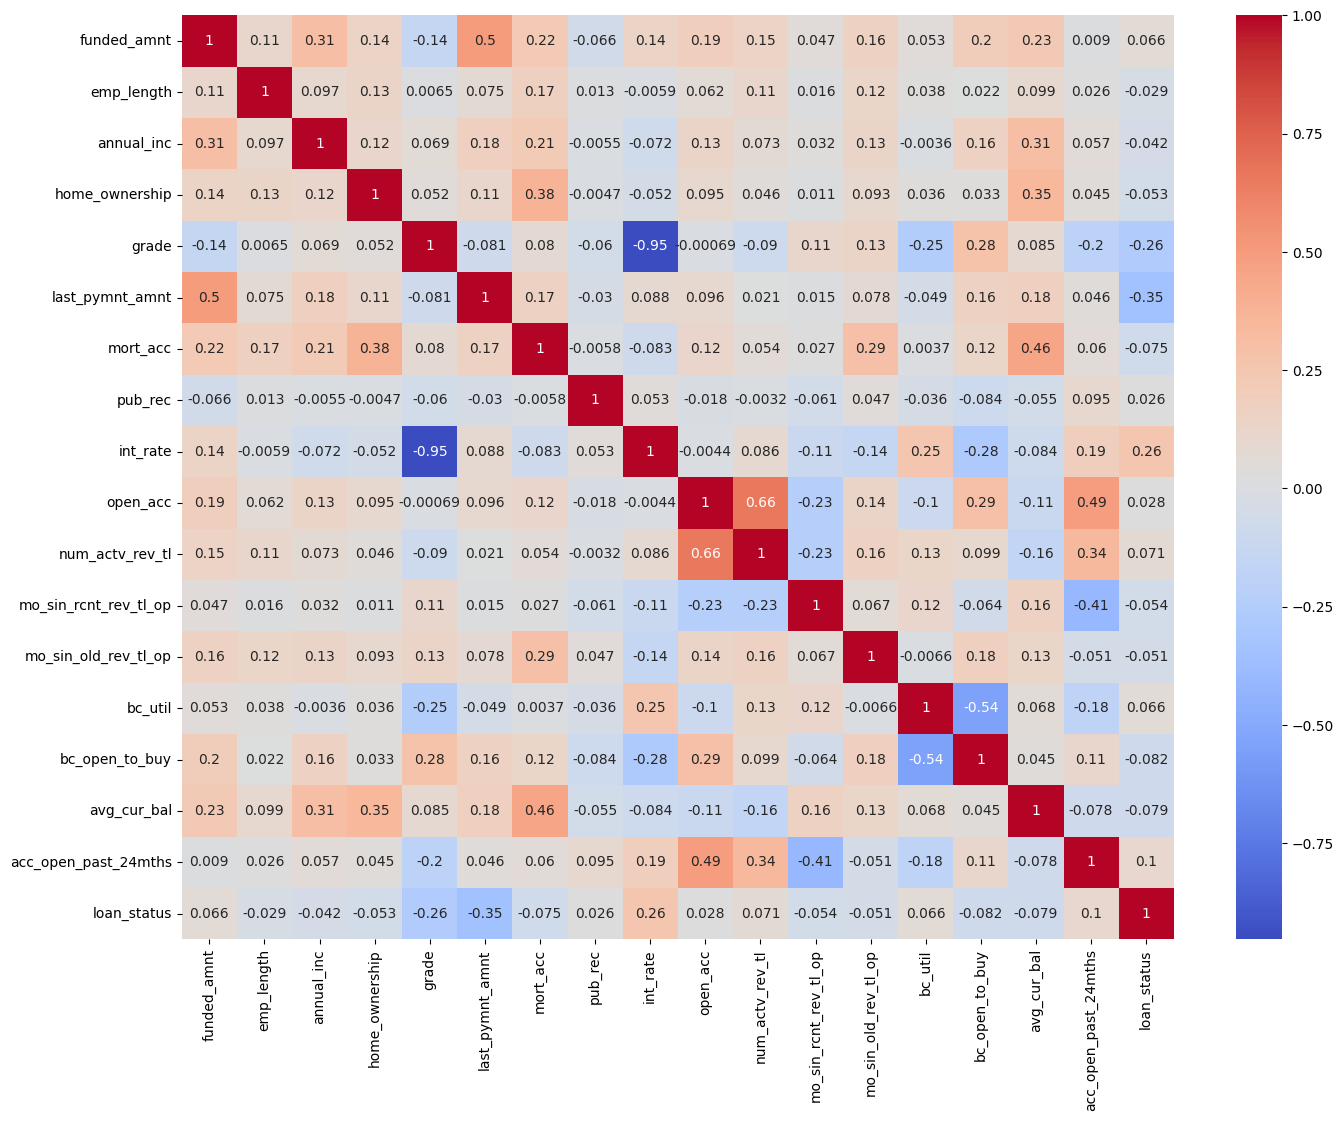

In [11]:
plt.figure(figsize=(16, 12))
sns.heatmap(Final_data.corr(), annot=True, cmap='coolwarm')

int_rate and grade columns are highly correlated. Let dive deep and investigate these features in detail

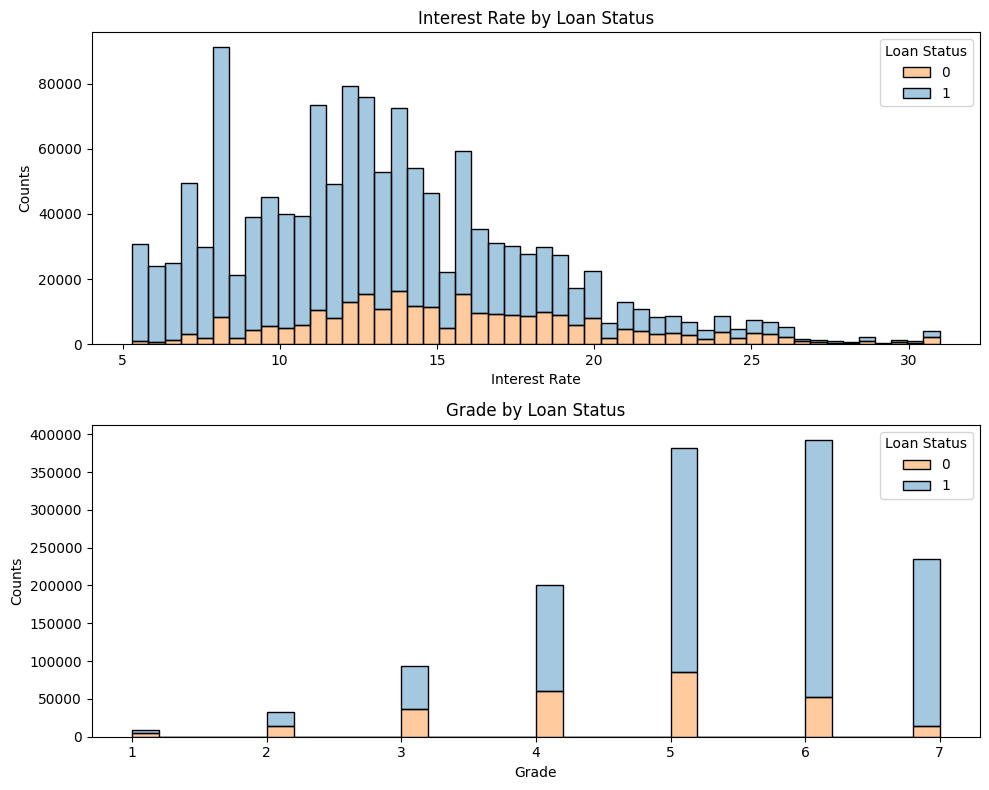

In [12]:

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot histogram for Interest Rate by Loan Status
sns.histplot(
    data=Final_data, 
    x='int_rate', 
    hue='loan_status', 
    multiple='stack', 
    bins=50, 
    alpha=0.4, 
    ax=axes[0]
)
axes[0].set_title("Interest Rate by Loan Status")
axes[0].set_xlabel('Interest Rate')
axes[0].set_ylabel('Counts')
# Customize legend
axes[0].legend(title='Loan Status', loc='upper right', labels=Final_data['loan_status'].unique())

# Plot histogram for Grade by Loan Status
sns.histplot(
    data=Final_data, 
    x='grade', 
    hue='loan_status', 
    multiple='stack', 
    bins=30, 
    alpha=0.4, 
    ax=axes[1]
)
axes[1].set_title("Grade by Loan Status")
axes[1].set_xlabel('Grade')
axes[1].set_ylabel('Counts')
# Customize legend
axes[1].legend(title='Loan Status', loc='upper right', labels=Final_data['loan_status'].unique())

# Adjust layout
plt.tight_layout()
plt.show()

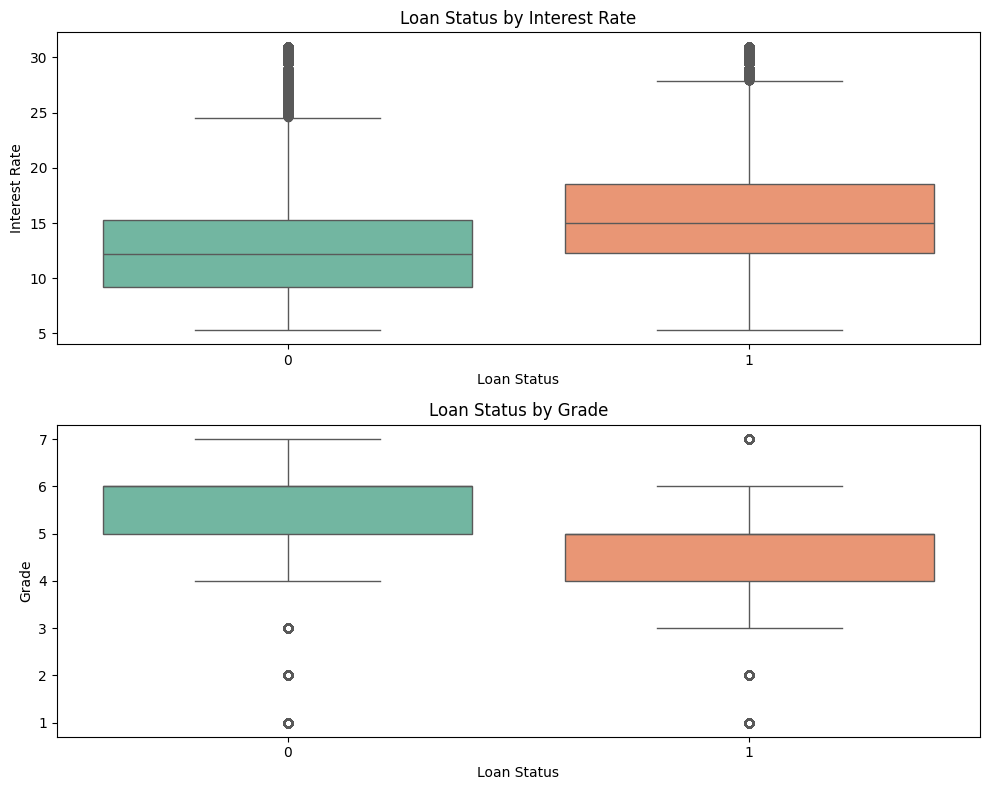

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Box plot for Interest Rate by Loan Status
sns.boxplot(
    data=Final_data, 
    x='loan_status', 
    y='int_rate', 
    ax=axes[0], 
    palette='Set2'
)
axes[0].set_title("Loan Status by Interest Rate")
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Interest Rate')

# Box plot for Grade by Loan Status
sns.boxplot(
    data=Final_data, 
    x='loan_status', 
    y='grade', 
    ax=axes[1], 
    palette='Set2'
)
axes[1].set_title("Loan Status by Grade")
axes[1].set_xlabel('Loan Status')
axes[1].set_ylabel('Grade')

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
Final_data.groupby(by='loan_status')['int_rate'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1076751.0,12.62,4.53,5.31,9.17,12.23,15.31,30.99
1,268559.0,15.71,4.91,5.31,12.29,15.05,18.55,30.99


In [15]:
Final_data.groupby(by='loan_status')['grade'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1076751.0,5.42,1.23,1.0,5.0,6.0,6.0,7.0
1,268559.0,4.58,1.32,1.0,4.0,5.0,5.0,7.0


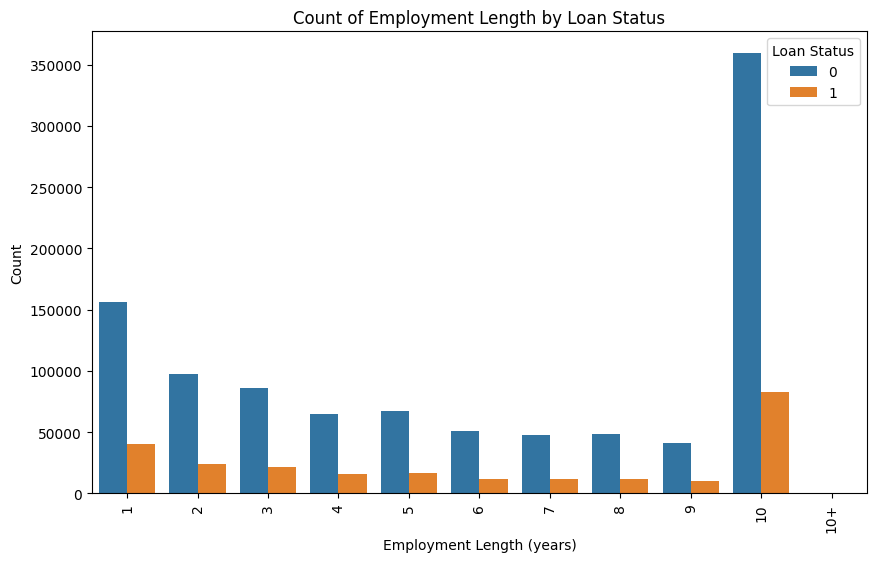

In [17]:
# Set the order for the employee length
order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '10+']

# Create a count plot for employment length by loan status
plt.figure(figsize=(10, 6))
g = sns.countplot(x='emp_length', data=Final_data, hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

# Set titles and labels
plt.title('Count of Employment Length by Loan Status')
plt.xlabel('Employment Length (years)')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

Correlation between Loan Status and Numeric Features

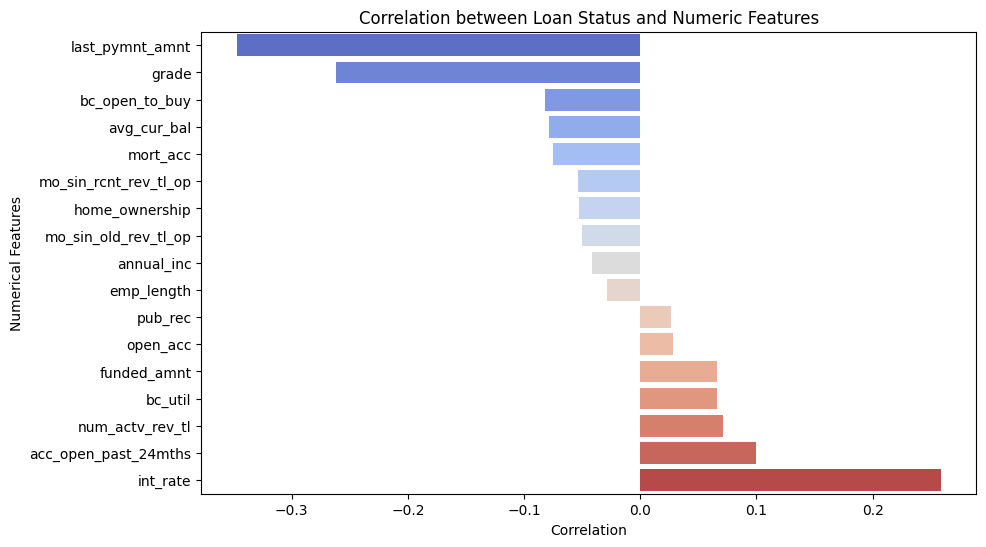

In [19]:
correlation = Final_data.corr()['loan_status'].drop('loan_status').sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.values, y=correlation.index, palette='coolwarm')
plt.title("Correlation between Loan Status and Numeric Features")
plt.xlabel('Correlation')
plt.ylabel('Numerical Features')
plt.show()

## Filling Missing values and Feature scaling 


<p>
<span style="color:blue">
> We have some important features which have some missing values. We filled those missing those values with the mean of the column. <br>
> We scaled the features all the features here using standard scaler. <br>
> We sampled our dataset here after infering from the learning curve plotted.
</span>
</p>

In [34]:
Final_data.fillna(Final_data.mean(),inplace = True)
HTML(Final_data.tail().to_html())
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (1345310, 18)


In [35]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = Final_data.columns.values[:-1]
data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean['loan_status'] = Final_data['loan_status']
data_clean['loan_status'].value_counts()

loan_status
0    1076751
1     268559
Name: count, dtype: int64

In [36]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5000)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5000)
data_clean = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)
data_clean.head()

Current shape of dataset : (10000, 18)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,-1.539238,-0.989868,0.139469,-0.570474,-0.968435,-0.760743,-0.850282,-0.357682,0.786455,-1.021874,-0.821504,-0.446807,-0.276605,0.892378,-0.617767,-0.566951,-0.221342,0
1,0.641383,1.151525,-0.160853,-0.570474,-0.968435,-0.692799,-0.850282,1.303822,0.694187,0.256948,0.732326,-0.697974,0.255410,1.051599,-0.589963,-0.589061,2.334317,1
2,-0.162004,1.151525,-0.346766,-2.048722,-1.740594,-0.713146,-0.850282,1.303822,1.520406,-1.021874,-0.821504,1.436947,0.049119,1.315762,-0.657373,-0.293510,-1.179715,0
3,-0.276773,0.616176,0.268178,-0.570474,0.575883,-0.608302,-0.850282,-0.357682,0.060893,0.805015,1.353857,-0.697974,-1.188630,-1.492322,3.484531,-0.748552,-0.540800,0
4,-0.965390,-1.257542,-0.003541,-0.570474,-0.196276,-0.761952,-0.850282,-0.357682,0.228653,-0.473807,-0.199972,-0.384015,-0.482896,-0.171509,0.025455,-0.702506,0.098115,1


<p>
<span style="color:blue">
Below are correlation values between the features finally selected.
</span>
</p>

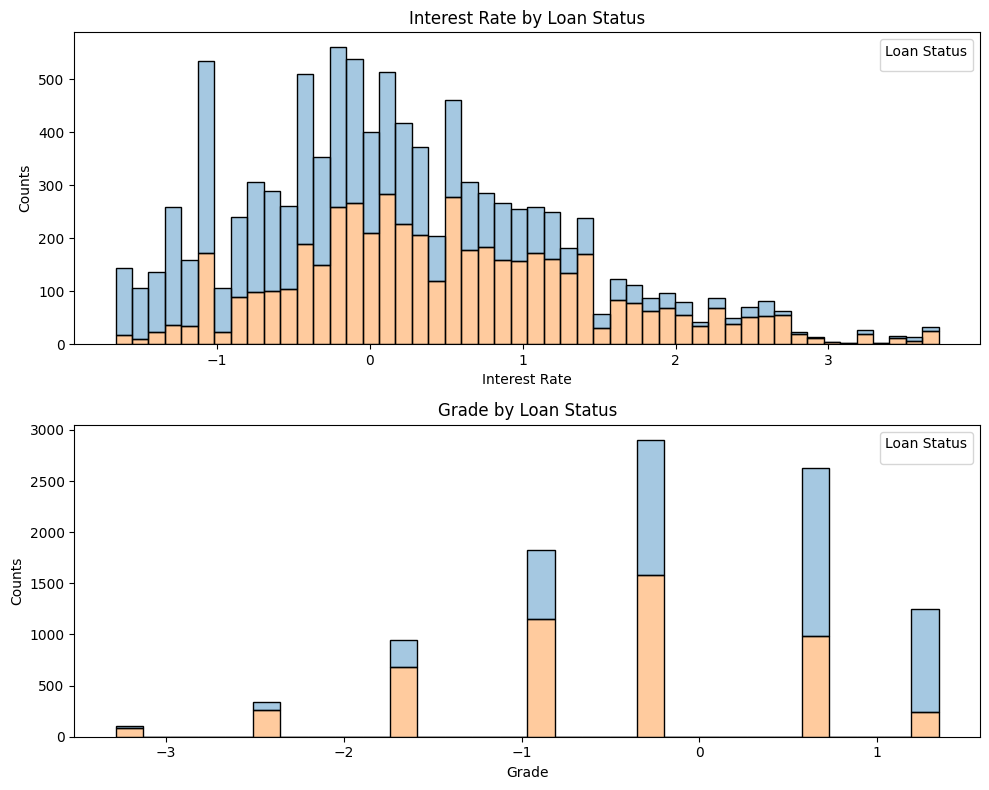

In [37]:

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot histogram for Interest Rate by Loan Status
sns.histplot(data=data_clean, x='int_rate', hue='loan_status', multiple='stack', bins=50, alpha=0.4, ax=axes[0])
axes[0].set_title("Interest Rate by Loan Status")
axes[0].set_xlabel('Interest Rate')
axes[0].set_ylabel('Counts')
axes[0].legend(title='Loan Status', loc='upper right')

# Plot histogram for Grade by Loan Status
sns.histplot(data=data_clean, x='grade', hue='loan_status', multiple='stack', bins=30, alpha=0.4, ax=axes[1])
axes[1].set_title("Grade by Loan Status")
axes[1].set_xlabel('Grade')
axes[1].set_ylabel('Counts')
axes[1].legend(title='Loan Status', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

## Learning Curve

<p>
<span style="color:blue">
> This learning curve clearly shows that our models are not learning anything after ~11,000 samples. So we randomly sampled our dataset and used only 11,000 samples of our dataset.<br>
> Note: In the plot, only ~9000 samples are shown because it is a plot for training set.
</span>
</p>

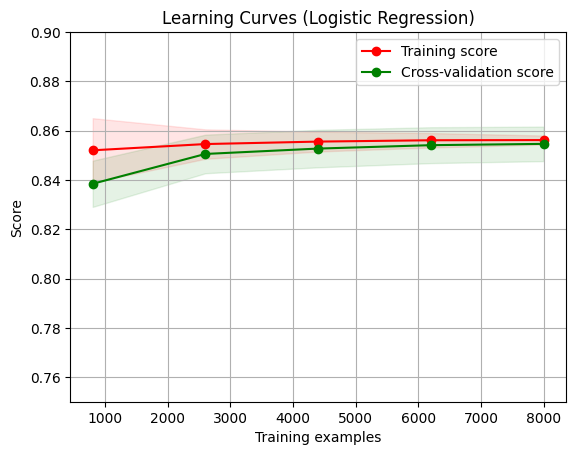

In [40]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

X, y = data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.75, 0.90), cv=cv, n_jobs=4)
plt.show()

## ROC Curve plot function

<p>
<span style="color:blue">
This is a callable ROC curve plot function. We have used this function to plot ROC Curve for all the models. We have used Seaborn package.
</span>
</p>

In [41]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

## Confusion Matrix Viz function

<p>
<span style="color:blue">
This is a callable Confusion Matrix Visualization function. We have used this function to visualize True positives, True Negatives, False Positives and False Negatives for all the models.
</span>
</p>

In [42]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.2, random_state=42)
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping

In [44]:
X_train.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths
9254,-0.965390,0.883851,1.054734,0.907775,1.348042,-0.157952,2.712103,-0.357682,-1.121816,1.535770,1.043091,-6.979743e-01,-4.720387e-01,-0.533376,0.559728,5.235998e-01,0.737030
1561,-0.276773,-0.989868,-0.089348,0.907775,-1.740594,0.815688,-0.341370,-0.357682,2.130633,-0.108430,-0.199972,-8.235579e-01,-8.846216e-01,-0.062949,-0.364132,-3.751763e-02,1.056487
1670,0.440536,-0.722194,-0.568432,-2.048722,-0.196276,-0.675341,-0.850282,-0.357682,-0.012502,-0.473807,-0.510738,8.718206e-01,-7.869046e-01,1.330237,-0.645571,-6.550113e-01,-1.499172
6087,-1.103114,-0.722194,-0.375368,-0.570474,0.575883,-0.549633,-0.850282,-0.357682,-0.440290,-1.204563,0.000000,-2.230813e-16,-3.085871e-16,-1.951892,0.969451,-3.437360e-16,-1.499172
6669,-0.506312,1.151525,0.067964,-2.048722,-0.968435,-0.710991,-0.850282,-0.357682,1.050678,1.535770,3.529219,-7.607661e-01,1.359782e-01,0.349578,-0.012217,-7.501267e-01,0.417572


###  Feature Selection using RFE (Recursive Feature Elimination) 

In [45]:
from sklearn.feature_selection import RFE
# create the RFE model and select 3 attributes
clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
rfe = RFE(estimator = clf_LR, n_features_to_select = 10)
rfe = rfe.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
# ['funded_amnt','emp_length','annual_inc','home_ownership','grade',"last_pymnt_amnt", "mort_acc", "pub_rec", 
# "int_rate", "open_acc","num_actv_rev_tl","mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
#"avg_cur_bal","acc_open_past_24mths",'loan_status']

[ True  True  True False  True  True False False  True  True False False
 False  True False  True  True]
[1 1 1 6 1 1 7 5 1 1 8 2 4 1 3 1 1]


In [46]:
#PCA (Principal Component Analysis)
from sklearn.decomposition import PCA 
pca = PCA(n_components=10, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print('Expected Variance is '+ str(explained_variance))

Expected Variance is [0.15913037 0.15021857 0.1193771  0.07767804 0.07425474 0.06547676
 0.05631339 0.05215881 0.04402991 0.04076005]


In [47]:
features = ['funded_amnt','annual_inc','grade',"last_pymnt_amnt", "int_rate",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy","acc_open_past_24mths","loan_status"]
X_train, X_test = X_train[features[:-1]], X_test[features[:-1]]
data_clean = data_clean[features]
print(X_train.shape)
print(data_clean.shape)

(8000, 10)
(10000, 11)


<Axes: >

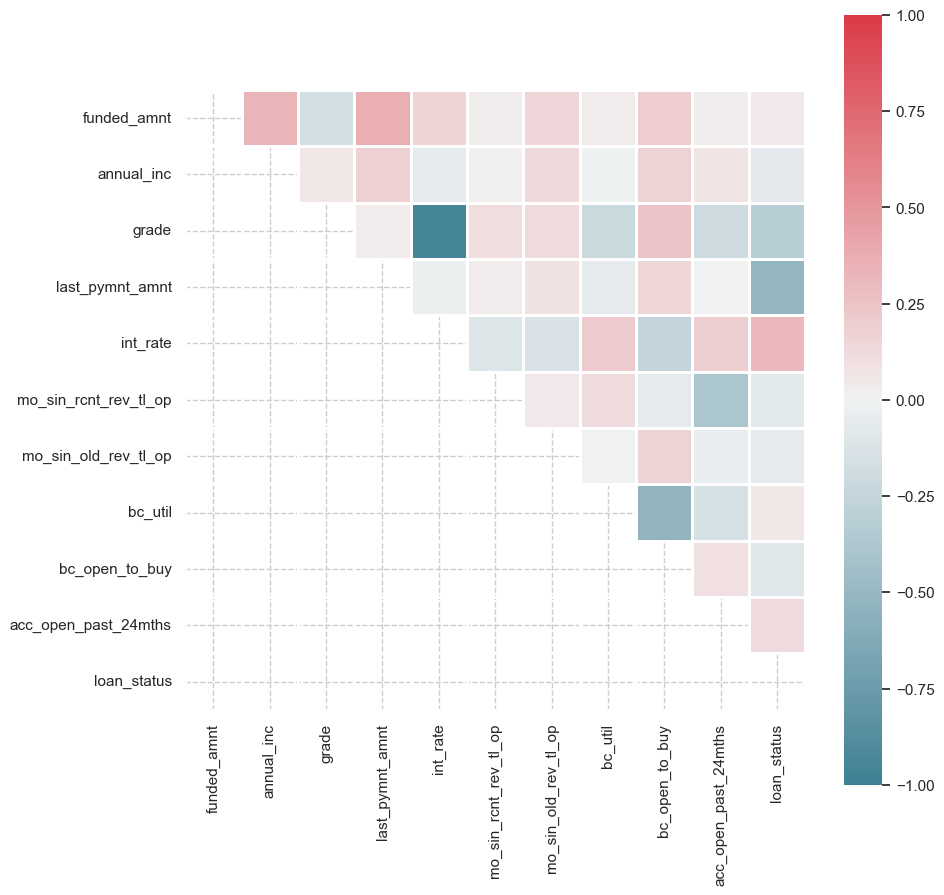

In [48]:
dataViz = data_clean
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

# Models


## Random Forest with randomized Search

<p>
<span style="color:blue">
Random forest when implemented with randomized search we got the best accuracies and minimum false negatives(predicting borowwer will not default eventhough he will. This might impact on the credibility of the company). We used the randomized search to find the best hyper paramters for the model.
</span>
</p>

In [49]:
from sklearn.model_selection  import RandomizedSearchCV
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,data_clean.shape[1])
param_dist = {'max_features': maxFeatures}
rand = RandomizedSearchCV(rf, param_distributions = param_dist, cv=10, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
rand.fit(X,y)
mean_scores = rand.cv_results_['mean_test_score']
print('Mean Scores:', mean_scores)
print('Best Accuracy:', rand.best_score_)
print('Best Estimator:', rand.best_estimator_)

Mean Scores: [0.8569 0.8669 0.8684 0.8707 0.8715 0.8694 0.8689 0.8698 0.8686 0.87  ]
Best Accuracy: 0.8714999999999999
Best Estimator: RandomForestClassifier(max_features=5, random_state=0)


In [50]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",max_features=rand.best_estimator_.max_features,random_state=0 )
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

0.87


## Feature Importance

Text(0, 0.5, 'Normalized Gini Importance')

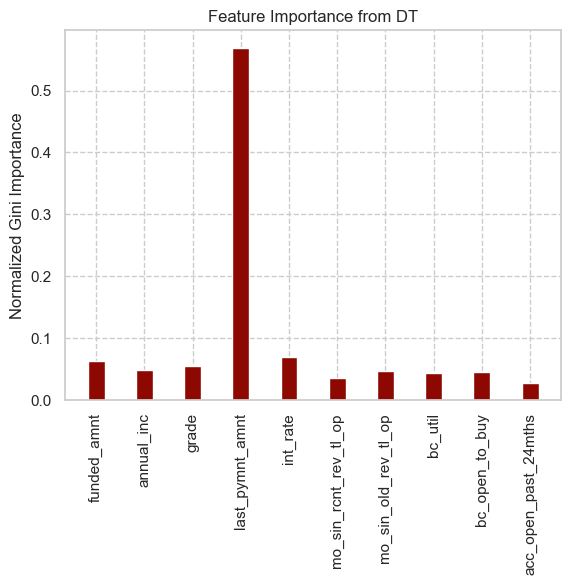

In [51]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(features)-1), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

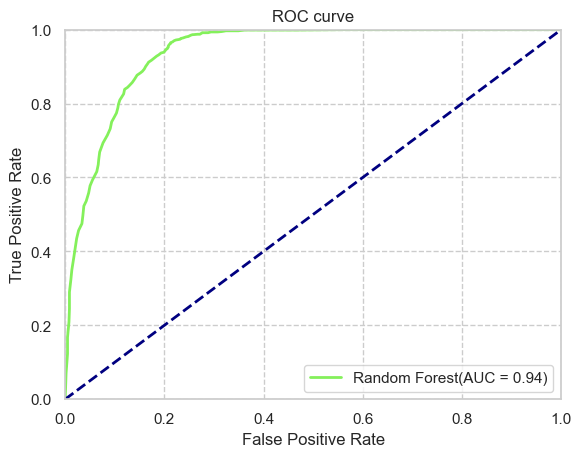

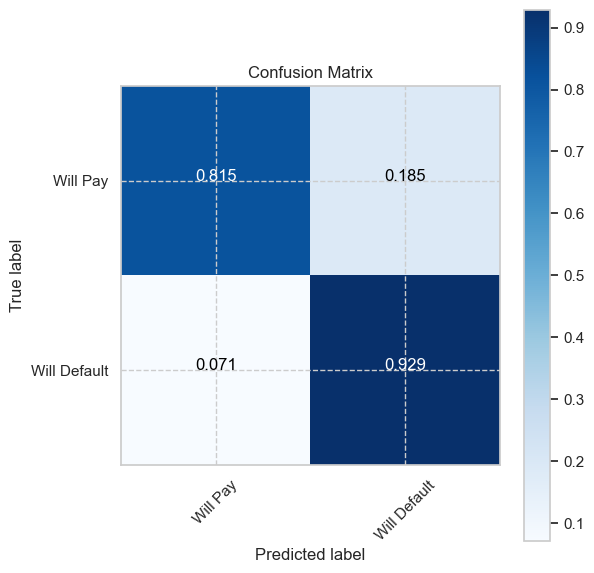

In [52]:
plotAUC(y_test,rfPredictproba, 'Random Forest')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.show()

## Logistic Regression with Grid Search


<p>
<span style="color:blue">
Logistic Regression when implemented with grid search we got the best accuracies and minimum false negatives. We used the randomized search to find the best hyper paramters for the model.
</span>
</p>

In [53]:
from sklearn.model_selection import GridSearchCV
def cross_validation_best_parameters(model, param_grid):
    grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = 10)
    X=data_clean.iloc[:,:-1].values
    y=data_clean.iloc[:,-1].values
    grid.fit(X,y)
    mean_scores = grid.cv_results_['mean_test_score']
    # Get best accuracy and best classifier
    best_accuracy = grid.best_score_
    best_classifier = grid.best_estimator_
    return mean_scores, best_accuracy, best_classifier
logreg = linear_model.LogisticRegression(random_state=0)
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c)
mean_scores, best_accuracy, best_classifier = cross_validation_best_parameters(logreg, param_grid)
print("Best accuracy is "+ str(best_accuracy))
print(best_classifier)

Best accuracy is 0.8562000000000001
LogisticRegression(C=10, random_state=0)


Logistic regression accuracy is  0.861


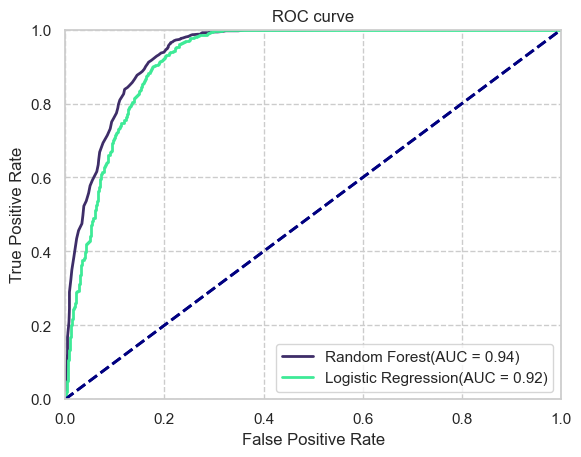

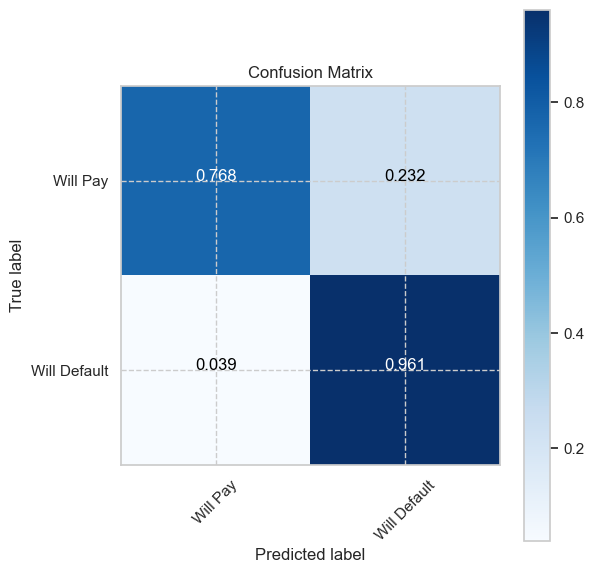

In [54]:
clf_LR = linear_model.LogisticRegression(C=best_classifier.C)
clf_LR.fit(X_train,y_train)
LR_Predict = clf_LR.predict_proba(X_test)[:,1]
LR_Predict_bin = clf_LR.predict(X_test)
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
print("Logistic regression accuracy is ",LR_Accuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(LR_Predict_bin, normalize=True)
plt.show()

## Support Vector Machines(SVM) with Grid Search CV

<p>
<span style="color:blue">
SVM (Support Vector Machines) when implemented with grid search, we got the best accuracies and minimum false negatives. We used the Grid search to find the best hyper paramters for the model.Later we used this value to find the predictions and plot the ROC curve.
</span>
</p>

In [55]:
from sklearn.model_selection import GridSearchCV    ## takes too much time to run this cell.
clf_svm = svm.SVC()
powers = range(0,5)
cs = [10**i for i in powers]
param_grid = {'C': cs}
grid = GridSearchCV(clf_svm, param_grid, cv=10, scoring='accuracy', n_jobs = -1, verbose=3)
X = data_clean.iloc[:, :-1].values
y = data_clean.iloc[:, -1].values
grid.fit(X, y)
grid_mean_scores = grid.cv_results_['mean_test_score']# create a list of the mean scores only
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
{'C': 10}
---------------
SVC(C=10)


SVM accuracy is  0.8525


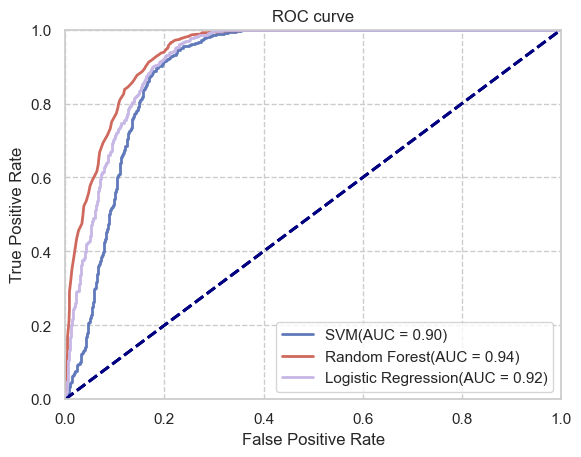

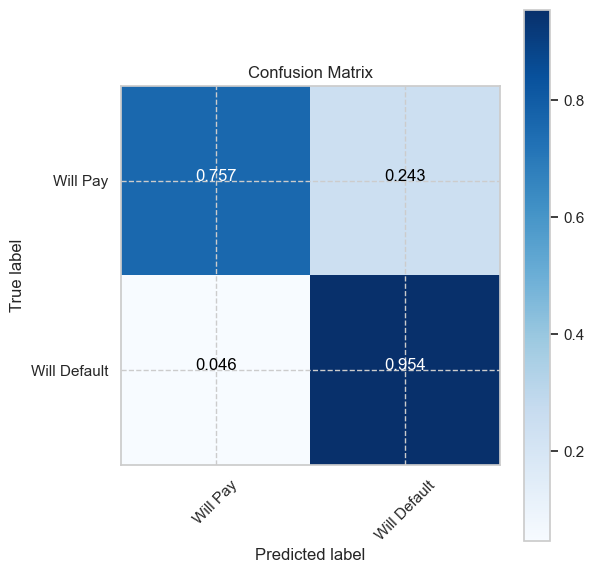

In [56]:
clf_svm = svm.SVC(kernel = "rbf", C=grid.best_estimator_.C)
clf_svm.fit(X_train.iloc[:,:],y_train)
predictions_svm = clf_svm.predict(X_test.iloc[:,:])
predictproba_svm = clf_svm.decision_function(X_test.iloc[:,:])
SVM_Accuracy = accuracy_score(y_test,predictions_svm)
print("SVM accuracy is ",SVM_Accuracy)
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predictions_svm, normalize=True)
plt.show()

## K Nearest Neighbors(KNN) with Grid Search CV

<p>
<span style="color:blue">
KNN (K Nearest Neighbors) when implemented with grid search, we got the best accuracies and minimum false negatives. 
We used the Grid search to find the best hyper paramters for the model.Later we used this value to find the predictions and plot the ROC curve.
</span>
</p>

In [57]:
#KNN_Acc = knnfunc(2,10) - 74.8 max, 75.7 for 15, 25 - 76.2, 30 - 76.1
from sklearn.model_selection import GridSearchCV    ## takes too much time to run this cell.
clf_knn = KNeighborsClassifier()
k_range = list(range(35, 50))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(clf_knn, param_grid, cv=10, scoring='accuracy')
X = data_clean.iloc[:, :-1].values
y = data_clean.iloc[:, -1].values
grid.fit(X, y)
grid_mean_scores = grid.cv_results_['mean_test_score']# create a list of the mean scores only
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'n_neighbors': 38}
---------------
KNeighborsClassifier(n_neighbors=38)


 38
KNN accuracy is  0.785


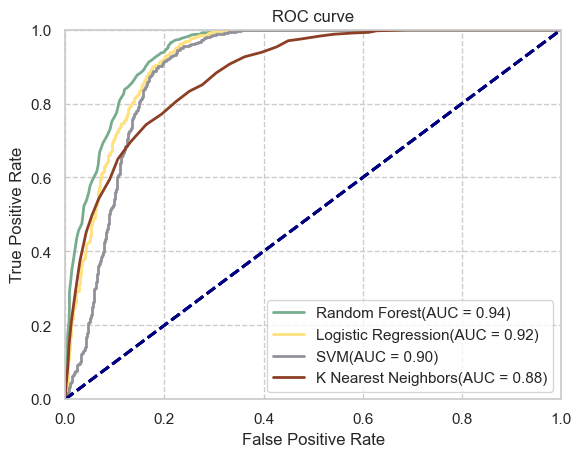

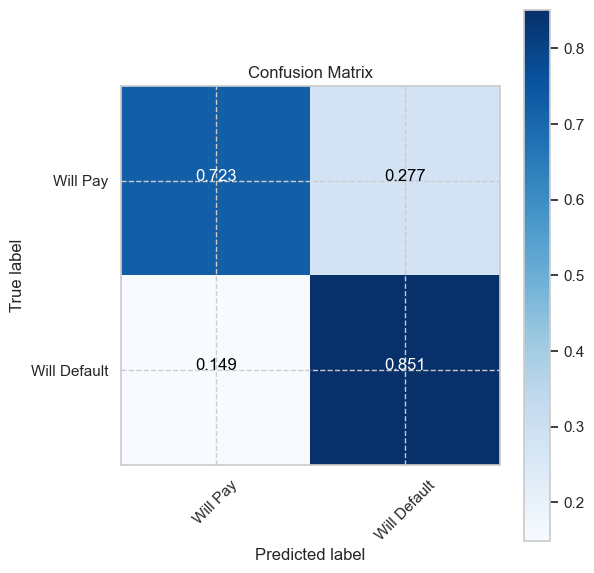

In [58]:
print("",grid.best_params_['n_neighbors'])
clf_knn_final = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])   #taking the the best from the above cell and using it to find predictions
clf_knn_final.fit(X_train,y_train)
knn_pred = clf_knn_final.predict(X_test)
knn_predictproba = clf_knn_final.predict_proba(X_test)[:,1]
KNN_Acc = accuracy_score(y_test,knn_pred)
print("KNN accuracy is ",KNN_Acc)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(knn_pred, normalize=True)
plt.show()

## Bagging for Classification

<p>
<span style="color:blue">
Our accuracy increased by 2 percent after using grid search and randomized search cross validation techniques. we have tried following ensemble algorithms to check if they can give better results. <br>
Bagging : <br>
> Create many random sub-samples of our dataset with replacement. <br>
> Train a CART(Classfication and Regression Trees) model on each sample.   <br>
> Given a new dataset, calculate the average prediction from each model <br>
</span>
</p>  

In [59]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
num_trees = 100
randomForest = RandomForestClassifier(random_state=seed)  # Initialize RandomForest properly
model = BaggingClassifier(estimator=randomForest, n_estimators=num_trees, random_state=seed)
X = data_clean.iloc[:, :-1].values
y = data_clean.iloc[:, -1].values
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print(f"Mean Accuracy: {results.mean()}")


Mean Accuracy: 0.8701000000000001


In [60]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
seed = 7
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
# Initialize the Logistic Regression classifier
clf_LR = LogisticRegression(C=1.0, max_iter=1000, random_state=seed)  # Adjusted hyperparameters if needed
model = BaggingClassifier(estimator=clf_LR, n_estimators=10, random_state=seed)
# Perform cross-validation
X = data_clean.iloc[:, :-1].values
y = data_clean.iloc[:, -1].values
results = model_selection.cross_val_score(model, X, y, cv=kfold)
# Print the average accuracy
print(f"Mean Accuracy: {results.mean():.4f}")

Mean Accuracy: 0.8548


## Ada Boost classifier

<p>
<span style="color:blue">
Ada Boost is one of the most commonly used ensemble algorithms. <br>
It works by weighting instances in the dataset by how easy or difficult they are to classify, allowing the algorithm to pay or or less attention to them in the construction of subsequent models. <br>
</span>
</p>  

In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
Ada_clf = AdaBoostClassifier(n_estimators=50, random_state=0)
# Use X and y for training and testing (as defined in previous cases)
X = data_clean.iloc[:, :-1].values
y = data_clean.iloc[:, -1].values
# Perform cross-validation with 5 folds and calculate accuracy
scores = cross_val_score(Ada_clf, X, y, cv=5, scoring='accuracy')
# Print the mean accuracy
print(f"Mean Accuracy: {scores.mean():.4f}")

Mean Accuracy: 0.8630


## Multi-Layer Perceptron Classifier

<p>
<span style="color:blue">
A multilayer perceptron (MLP) is a feedforward artificial neural network. An MLP consists of at least three layers of nodes. MLP utilizes a supervised learning technique called backpropagation for training.Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable. We got our highest accuracy for MLP classifier(little higher than Logistic Regression with Grid Search CV).
</span>
</p>

0.8605


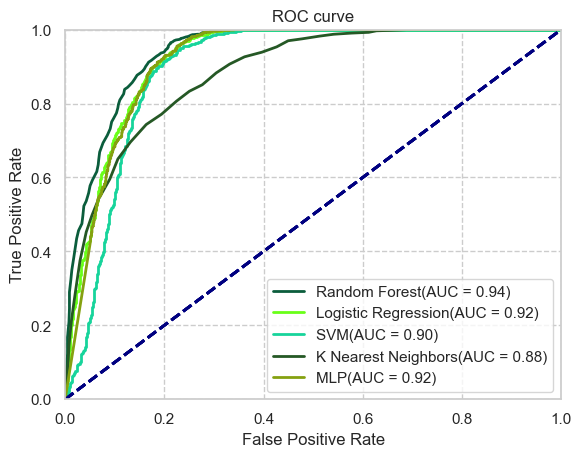

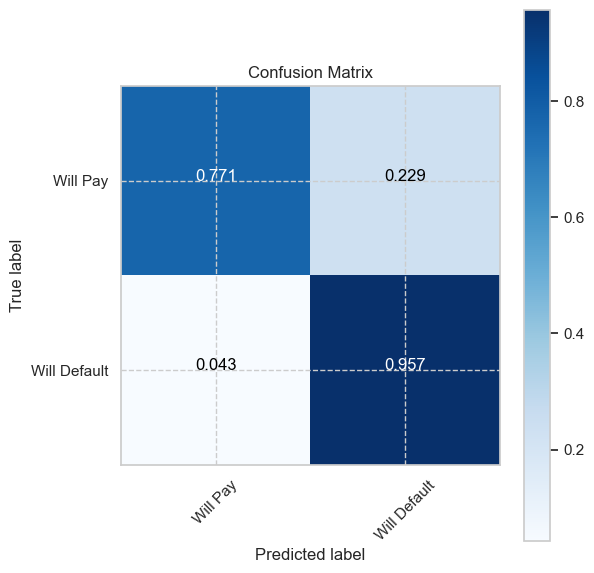

In [62]:
from sklearn.neural_network import MLPClassifier
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf_NN.fit(X_train,y_train)     
predict_NN = clf_NN.predict(X_test)
predictproba_NN = clf_NN.predict_proba(X_test)[:,1]
NNAccuracy = accuracy_score(y_test,predict_NN)
print(NNAccuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plotAUC(y_test,predictproba_NN,'MLP')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predict_NN, normalize=True)
plt.show()

## Artificial Neural Networks (ANN)

In [132]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    assert len(dropout_rates) == len(hidden_units) + 1, "Dropout rates must have one more element than hidden units."
    inp = Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

Convert to numpy arrays

In [144]:
X_nn_train = np.array(X_train)
y_nn_train = np.array(y_train)
X_nn_test = np.array(X_test)
y_nn_test = np.array(y_test)

In [145]:
num_columns = X_nn_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_test, y_nn_test),
    epochs=20,
    batch_size=32
)

ValueError: object __array__ method not producing an array

## Precision,recall,F1score for all models

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
from tabulate import tabulate
reports = {
    "RF" : classification_report(y_test, rfPredict, target_names=["Will Pay", "Will Default"], output_dict=True),
    "SVM" : classification_report(y_test, predictions_svm, target_names=["Will Pay", "Will Default"], output_dict=True),
    "LR" : classification_report(y_test, LR_Predict_bin, target_names=["Will Pay", "Will Default"], output_dict=True),
    "KNN" : classification_report(y_test, knn_pred, target_names=["Will Pay", "Will Default"], output_dict=True),
    "MLP" : classification_report(y_test, predict_NN, target_names=["Will Pay", "Will Default"], output_dict=True)
}

df_reports = pd.concat([pd.DataFrame(report).transpose() for report in reports.values()], keys = reports.keys())
print(tabulate(df_reports, headers = 'keys', tablefmt = 'fancy_grid'))


In [ ]:
df_reports

## Behaviour of models with different sample sizes of dataset

<p>
<span style="color:blue">
Here we have plotted ROC_AUC_Score for different sample sizes similar to what we have done in one of the assignments.
</span>
</p>

In [44]:
def modBootstrapper(train, test, nruns, sampsize, model, c):
    target = 'loan_status'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)] #selecting random indexes for KFold
        if (model == "LR"):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target, axis = 1), train_samp[target]) #Logistic regression
            p = lr_i.predict_proba(test.drop(target, axis = 1))[:,1]
        elif (model == "SVM"):
            svm_i = svm.SVC(kernel='rbf', C = c) 
            svm_i.fit(train_samp.drop(target, axis = 1), train_samp[target])#SVM fitting and predicting if lr==0
            p = svm_i.decision_function(test.drop(target, axis = 1))
        elif (model == "RF"):
            RF_i = RandomForestClassifier(bootstrap=True,criterion = "gini")
            RF_i.fit(train_samp.drop(target, axis = 1), train_samp[target])
            p = RF_i.predict_proba(X_test)[:,1]
        elif (model == "KNN"):
            knn_i = KNeighborsClassifier(n_neighbors= 30) #taking the the best from the above cell and using it to find predictions
            knn_i.fit(train_samp.drop(target, axis = 1), train_samp[target])
            p = knn_i.predict_proba(X_test)[:,1]
            
        aucs_boot.append(metrics.roc_auc_score(test[target], p)) #calculating auc scores for each bag in bootstrapping
    
    return [np.mean(aucs_boot), np.sqrt(np.var(aucs_boot))] #mean, standard error = square root of variance

In [ ]:
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping
SampleSizes = [250,1000,1500,2000,2750,3750,4500,5200,6500,7000,8000,8500,9000,10000,11000] #various samples of Dataset
LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
RF_means = []
RF_stderr = []
KNN_means = []
KNN_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(bs_train, bs_test, 20, n, "LR", 0.1)# collecting means and stderrs for LR model
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(bs_train, bs_test, 20, n,"SVM", 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)
    mean3, err3 = modBootstrapper(bs_train, bs_test, 20, n,"RF", 0.1)# collecting means and stderrs for SVM model
    RF_means.append(mean3)
    RF_stderr.append(err3)
    mean4, err4 = modBootstrapper(bs_train, bs_test, 20, n,"KNN", 0.1)# collecting means and stderrs for SVM model
    KNN_means.append(mean4)
    KNN_stderr.append(err4)
    print(n)  

In [ ]:
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r+-', label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r--',  label = 'LR means + stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.plot(np.log2(SampleSizes), RF_means, 'b', label = 'RF means')
plt.plot(np.log2(SampleSizes), RF_means + np.array(RF_stderr), 'b+-', label = 'RF means + stderr')
plt.plot(np.log2(SampleSizes), RF_means - np.array(RF_stderr), 'b--', label = 'RF means - stderr')

plt.plot(np.log2(SampleSizes), KNN_means, 'm', label = 'KNN means')
plt.plot(np.log2(SampleSizes), KNN_means + np.array(KNN_stderr), 'm+-', label = 'KNN means + stderr')
plt.plot(np.log2(SampleSizes), KNN_means - np.array(KNN_stderr), 'm--', label = 'KNN means - stderr')

plt.legend(bbox_to_anchor=(1.20, 0.5),loc = 10)
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')